In [1]:
pip install torch


Note: you may need to restart the kernel to use updated packages.


/Users/tim/anaconda3/envs/torch/lib/python3.9/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


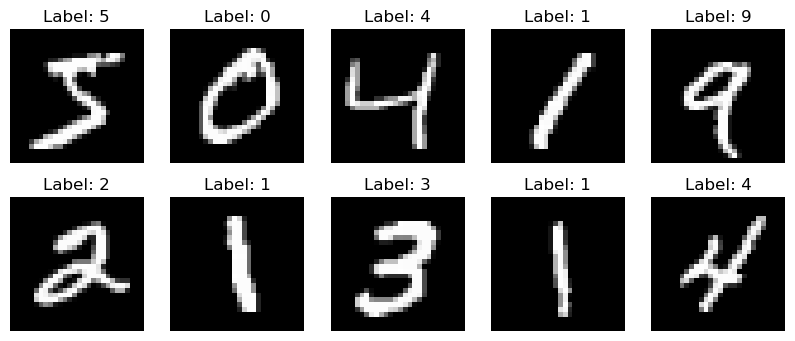

In [2]:
import torch
import numpy as np
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
import matplotlib.ticker as ticker

# Check if mps is available
#device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# Load the MNIST dataset
mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)
# Convert data and target to numpy arrays
data = mnist.data
target = mnist.target.astype(np.uint8)  # convert labels from string to integer

# Split into training and testing sets
train_imgs = data[:6000]
train_labels = target[:6000]
test_imgs = data[69000:]
test_labels = target[69000:]

# Visualize some images and labels
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in enumerate(axes.flat):
    ax.imshow(train_imgs[i].reshape(28, 28), cmap='gray')
    ax.set_title("Label: {}".format(train_labels[i]))
    ax.axis('off')

plt.show()

# Convert numpy arrays to PyTorch tensors
train_imgs = torch.from_numpy(train_imgs).float()
train_labels = torch.from_numpy(train_labels)
test_imgs = torch.from_numpy(test_imgs).float()
test_labels = torch.from_numpy(test_labels)

# Create data loaders
train_dataset = TensorDataset(train_imgs, train_labels)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

test_dataset = TensorDataset(test_imgs, test_labels)
test_loader = DataLoader(test_dataset, batch_size=1)



Training with learning rate: 0.0001
Epoch 1, Accuracy: 84.7%
Epoch 2, Accuracy: 84.9%
Epoch 3, Accuracy: 90.1%
Epoch 4, Accuracy: 89.7%
Epoch 5, Accuracy: 91.4%
Epoch 6, Accuracy: 90.8%
Epoch 7, Accuracy: 91.5%
Epoch 8, Accuracy: 90.6%
Epoch 9, Accuracy: 91.5%
Epoch 10, Accuracy: 92.0%
Epoch 11, Accuracy: 91.8%
Epoch 12, Accuracy: 91.1%
Epoch 13, Accuracy: 91.5%
Epoch 14, Accuracy: 92.6%
Epoch 15, Accuracy: 92.2%
Epoch 16, Accuracy: 92.1%
Epoch 17, Accuracy: 92.4%
Epoch 18, Accuracy: 92.9%
Epoch 19, Accuracy: 92.6%
Epoch 20, Accuracy: 92.7%
Epoch 21, Accuracy: 93.2%
Epoch 22, Accuracy: 93.1%
Epoch 23, Accuracy: 93.0%
Epoch 24, Accuracy: 93.1%
Epoch 25, Accuracy: 93.1%
Epoch 26, Accuracy: 93.0%
Epoch 27, Accuracy: 92.7%
Epoch 28, Accuracy: 92.6%
Epoch 29, Accuracy: 92.7%
Epoch 30, Accuracy: 92.8%
Epoch 31, Accuracy: 92.4%
Epoch 32, Accuracy: 92.7%
Epoch 33, Accuracy: 92.7%
Epoch 34, Accuracy: 92.5%
Epoch 35, Accuracy: 92.4%
Epoch 36, Accuracy: 92.6%
Epoch 37, Accuracy: 92.7%
Epoch 38, A

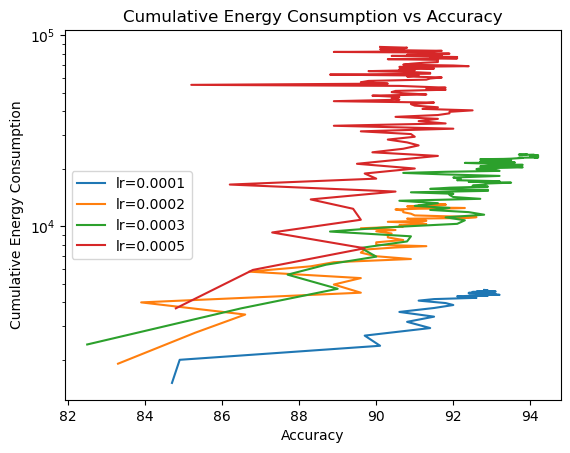

In [12]:
class FFNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FFNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)

    def forward(self, x):
        x = self.leaky_relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the network
input_dim = 784  # MNIST images are 28x28
hidden_dim = 100
output_dim = 10  # 10 classes

learning_rates = [0.0001, 0.0002, 0.0003, 0.0005]
for lr in learning_rates:
    print(f'Training with learning rate: {lr}')
    model = FFNN(input_dim, hidden_dim, output_dim)
    # Move the model to GPU if available
    #model.to(device)
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    # Training
    epochs = 100
    best_accuracy = 0
    epochs_without_improvement = 0
    accuracies = []
    cumulative_energy_consumption = 0
    energy_consumptions = []
    for epoch in range(epochs):
        energy_consumption = 0
        for images, labels in train_loader:
            # Move images and labels to GPU if available
            #images = images.to(device)
            #labels = labels.to(device)
            # Clear gradients
            optimizer.zero_grad()
            # Forward propagation
            outputs = model(images)
            # Calculate loss
            loss = criterion(outputs, labels)
            # Backpropagation
            loss.backward()
            # Save the current weights
            weights_before_update = [w.clone() for w in model.parameters()]
            # Update weights
            optimizer.step()
            # Calculate the size of the weight updates using L1 norm
            weight_updates = [weights_before_update[i] - w for i, w in enumerate(model.parameters())]
            weight_update_sizes = [w.abs().sum().item() for w in weight_updates]  # L1 norm
            # Estimate the energy consumption as the sum of the weight update sizes
            energy_consumption += sum(weight_update_sizes)
        cumulative_energy_consumption += energy_consumption
        energy_consumptions.append(cumulative_energy_consumption)

        # Test
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                #images = images.to(device)
                #labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        accuracies.append(accuracy)
        print(f'Epoch {epoch+1}, Accuracy: {accuracy}%')

        # Stop training if accuracy reaches 95%
        if accuracy >= 95:
            print(f'Stopping training after reaching {accuracy}% accuracy.')
            break

    plt.semilogy(accuracies, energy_consumptions, label=f'lr={lr}')

plt.xlabel('Accuracy')
plt.ylabel('Cumulative Energy Consumption')
plt.title('Cumulative Energy Consumption vs Accuracy')
plt.legend()
plt.show()


Training with hidden_dim=100, num_layers=1
Epoch 1, Accuracy: 83.0%
Epoch 2, Accuracy: 86.9%
Epoch 3, Accuracy: 87.7%
Epoch 4, Accuracy: 90.2%
Epoch 5, Accuracy: 89.2%
Epoch 6, Accuracy: 90.3%
Epoch 7, Accuracy: 89.5%
Epoch 8, Accuracy: 91.0%
Epoch 9, Accuracy: 90.6%
Epoch 10, Accuracy: 91.1%
Epoch 11, Accuracy: 90.7%
Epoch 12, Accuracy: 92.9%
Epoch 13, Accuracy: 92.2%
Epoch 14, Accuracy: 92.1%
Epoch 15, Accuracy: 92.4%
Epoch 16, Accuracy: 91.8%
Epoch 17, Accuracy: 90.6%
Epoch 18, Accuracy: 91.7%
Epoch 19, Accuracy: 91.4%
Epoch 20, Accuracy: 90.2%
Epoch 21, Accuracy: 90.1%
Epoch 22, Accuracy: 91.1%
Epoch 23, Accuracy: 93.0%
Epoch 24, Accuracy: 92.1%
Epoch 25, Accuracy: 92.4%
Epoch 26, Accuracy: 93.0%
Epoch 27, Accuracy: 91.2%
Epoch 28, Accuracy: 92.9%
Epoch 29, Accuracy: 92.9%
Epoch 30, Accuracy: 93.4%
Epoch 31, Accuracy: 93.7%
Epoch 32, Accuracy: 94.1%
Epoch 33, Accuracy: 93.9%
Epoch 34, Accuracy: 94.2%
Epoch 35, Accuracy: 93.5%
Epoch 36, Accuracy: 94.2%
Epoch 37, Accuracy: 91.3%
Epoc

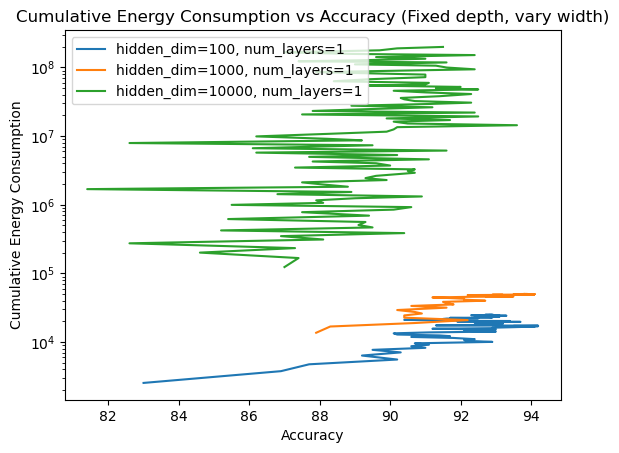

Elapsed time: 6321.987383842468 seconds


In [6]:
import time
# Check if mps is available
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
class FFNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(FFNN, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_dim, hidden_dim))  # input layer
        for _ in range(num_layers - 1):  # hidden layers
            self.layers.append(nn.Linear(hidden_dim, hidden_dim))
        self.layers.append(nn.Linear(hidden_dim, output_dim))  # output layer
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)

    def forward(self, x):
        for layer in self.layers[:-1]:  # all layers except last one
            x = self.leaky_relu(layer(x))
        x = self.layers[-1](x)  # last layer without activation
        return x

# Instantiate the network
input_dim = 784  # MNIST images are 28x28
hidden_dim = 100
output_dim = 10  # 10 classes
    
# Check if mps is available
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Define the structure variations
width_variations = [100, 1000, 10000]
lr=0.0003

start_time = time.time()

# Fixed depth, vary width
for hidden_dim in width_variations:
    print(f'Training with hidden_dim={hidden_dim}, num_layers=1')

    # Instantiate the network with the specified structure
    model = FFNN(input_dim, hidden_dim, output_dim, 1)
    # Move the model to GPU if available
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    # Training
    epochs = 100
    best_accuracy = 0
    epochs_without_improvement = 0
    accuracies = []
    cumulative_energy_consumption = 0
    energy_consumptions = []
    for epoch in range(epochs):
        energy_consumption = 0
        for images, labels in train_loader:
            # Move images and labels to GPU if available
            images = images.to(device)
            labels = labels.to(device)
            # Clear gradients
            optimizer.zero_grad()
            # Forward propagation
            outputs = model(images)
            # Calculate loss
            loss = criterion(outputs, labels)
            # Backpropagation
            loss.backward()
            # Save the current weights
            weights_before_update = [w.clone() for w in model.parameters()]
            # Update weights
            optimizer.step()
            # Calculate the size of the weight updates using L1 norm
            weight_updates = [weights_before_update[i] - w for i, w in enumerate(model.parameters())]
            weight_update_sizes = [w.abs().sum().item() for w in weight_updates]  # L1 norm
            # Estimate the energy consumption as the sum of the weight update sizes
            energy_consumption += sum(weight_update_sizes)
        cumulative_energy_consumption += energy_consumption
        energy_consumptions.append(cumulative_energy_consumption)

        # Test
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        accuracies.append(accuracy)
        print(f'Epoch {epoch+1}, Accuracy: {accuracy}%')

        # Stop training if accuracy reaches 95%
        if accuracy >= 95:
            print(f'Stopping training after reaching {accuracy}% accuracy.')
            break

    plt.semilogy(accuracies, energy_consumptions, label=f'hidden_dim={hidden_dim}, num_layers=1')

plt.xlabel('Accuracy')
plt.ylabel('Cumulative Energy Consumption')
plt.title('Cumulative Energy Consumption vs Accuracy (Fixed depth, vary width)')
plt.legend()
plt.show()

end_time = time.time()

elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")


Training with hidden_dim=100, num_layers=1
Epoch 1, Accuracy: 83.3%
Epoch 2, Accuracy: 88.1%
Epoch 3, Accuracy: 87.7%
Epoch 4, Accuracy: 88.4%
Epoch 5, Accuracy: 89.2%
Epoch 6, Accuracy: 90.6%
Epoch 7, Accuracy: 89.9%
Epoch 8, Accuracy: 91.6%
Epoch 9, Accuracy: 86.6%
Epoch 10, Accuracy: 91.6%
Epoch 11, Accuracy: 92.8%
Epoch 12, Accuracy: 91.6%
Epoch 13, Accuracy: 92.3%
Epoch 14, Accuracy: 92.4%
Epoch 15, Accuracy: 91.9%
Epoch 16, Accuracy: 93.4%
Epoch 17, Accuracy: 92.4%
Epoch 18, Accuracy: 92.3%
Epoch 19, Accuracy: 92.7%
Epoch 20, Accuracy: 92.8%
Epoch 21, Accuracy: 92.7%
Epoch 22, Accuracy: 92.2%
Epoch 23, Accuracy: 92.7%
Epoch 24, Accuracy: 92.7%
Epoch 25, Accuracy: 92.6%
Epoch 26, Accuracy: 92.4%
Epoch 27, Accuracy: 91.8%
Epoch 28, Accuracy: 92.4%
Epoch 29, Accuracy: 91.5%
Epoch 30, Accuracy: 93.2%
Epoch 31, Accuracy: 93.4%
Epoch 32, Accuracy: 93.7%
Epoch 33, Accuracy: 92.9%
Epoch 34, Accuracy: 90.8%
Epoch 35, Accuracy: 93.0%
Epoch 36, Accuracy: 93.1%
Epoch 37, Accuracy: 92.4%
Epoc

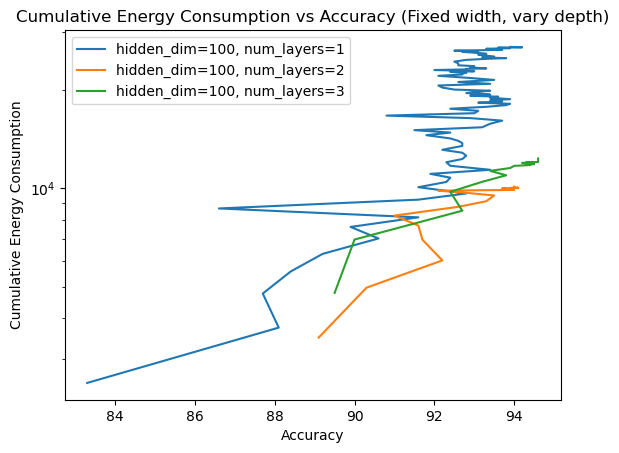

Elapsed time: 776.8122470378876 seconds


In [10]:
depth_variations = [1, 2, 3]
lr=0.0003
start_time = time.time()
# Fixed width, vary depth
for num_layers in depth_variations:
    print(f'Training with hidden_dim=100, num_layers={num_layers}')

    # Instantiate the network with the specified structure
    model = FFNN(input_dim, 100, output_dim, num_layers)
    # Move the model to GPU if available
    #model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    # Training
    epochs = 100
    best_accuracy = 0
    epochs_without_improvement = 0
    accuracies = []
    cumulative_energy_consumption = 0
    energy_consumptions = []
    for epoch in range(epochs):
        energy_consumption = 0
        for images, labels in train_loader:
            # Move images and labels to GPU if available
            #images = images.to(device)
            #labels = labels.to(device)
            # Clear gradients
            optimizer.zero_grad()
            # Forward propagation
            outputs = model(images)
            # Calculate loss
            loss = criterion(outputs, labels)
            # Backpropagation
            loss.backward()
            # Save the current weights
            weights_before_update = [w.clone() for w in model.parameters()]
            # Update weights
            optimizer.step()
            # Calculate the size of the weight updates using L1 norm
            weight_updates = [weights_before_update[i] - w for i, w in enumerate(model.parameters())]
            weight_update_sizes = [w.abs().sum().item() for w in weight_updates]  # L1 norm
            # Estimate the energy consumption as the sum of the weight update sizes
            energy_consumption += sum(weight_update_sizes)
        cumulative_energy_consumption += energy_consumption
        energy_consumptions.append(cumulative_energy_consumption)

        # Test
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                #images = images.to(device)
                #labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        accuracies.append(accuracy)
        print(f'Epoch {epoch+1}, Accuracy: {accuracy}%')

        # Stop training if accuracy reaches 95%
        if accuracy >= 95:
            print(f'Stopping training after reaching {accuracy}% accuracy.')
            break

    plt.semilogy(accuracies, energy_consumptions, label=f'hidden_dim=100, num_layers={num_layers}')

plt.xlabel('Accuracy')
plt.ylabel('Cumulative Energy Consumption')
plt.title('Cumulative Energy Consumption vs Accuracy (Fixed width, vary depth)')
plt.legend()
plt.show()

end_time = time.time()

elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")


Training with hidden_dim=100, num_layers=1
Epoch 1, Accuracy: 81.0%
Epoch 2, Accuracy: 87.1%
Epoch 3, Accuracy: 87.2%
Epoch 4, Accuracy: 87.1%
Epoch 5, Accuracy: 90.4%
Epoch 6, Accuracy: 89.4%
Epoch 7, Accuracy: 88.2%
Epoch 8, Accuracy: 87.6%
Epoch 9, Accuracy: 90.2%
Epoch 10, Accuracy: 88.5%
Epoch 11, Accuracy: 91.2%
Epoch 12, Accuracy: 90.8%
Epoch 13, Accuracy: 90.4%
Epoch 14, Accuracy: 91.1%
Epoch 15, Accuracy: 91.2%
Epoch 16, Accuracy: 90.6%
Epoch 17, Accuracy: 90.8%
Epoch 18, Accuracy: 90.7%
Epoch 19, Accuracy: 91.9%
Epoch 20, Accuracy: 92.4%
Epoch 21, Accuracy: 91.9%
Epoch 22, Accuracy: 91.1%
Epoch 23, Accuracy: 91.0%
Epoch 24, Accuracy: 91.9%
Epoch 25, Accuracy: 90.3%
Epoch 26, Accuracy: 91.2%
Epoch 27, Accuracy: 90.9%
Epoch 28, Accuracy: 91.5%
Epoch 29, Accuracy: 91.9%
Epoch 30, Accuracy: 91.6%
Epoch 31, Accuracy: 92.6%
Epoch 32, Accuracy: 91.8%
Epoch 33, Accuracy: 92.0%
Epoch 34, Accuracy: 91.4%
Epoch 35, Accuracy: 91.7%
Epoch 36, Accuracy: 90.2%
Epoch 37, Accuracy: 90.9%
Epoc

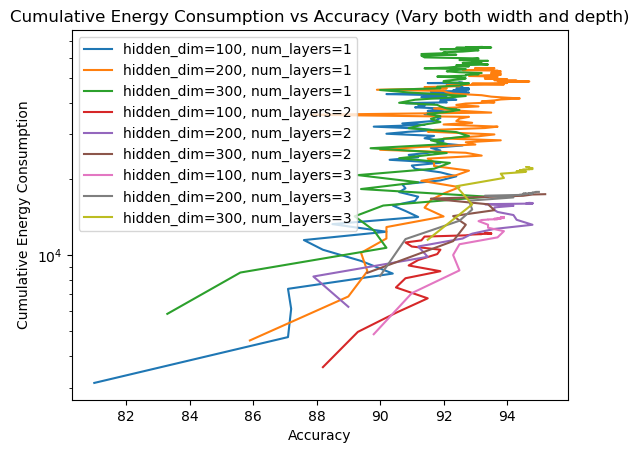

In [11]:
structure_variations = [(100, 1), (200, 1), (300, 1), (100, 2), (200, 2), (300, 2), (100, 3), (200, 3), (300, 3)]
lr=0.0004

# Vary both width and depth
for hidden_dim, num_layers in structure_variations:
    print(f'Training with hidden_dim={hidden_dim}, num_layers={num_layers}')

    # Instantiate the network with the specified structure
    model = FFNN(input_dim, hidden_dim, output_dim, num_layers)
    # Move the model to GPU if available
    #model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    # Training
    epochs = 100
    best_accuracy = 0
    epochs_without_improvement = 0
    accuracies = []
    cumulative_energy_consumption = 0
    energy_consumptions = []
    for epoch in range(epochs):
        energy_consumption = 0
        for images, labels in train_loader:
            # Move images and labels to GPU if available
            #images = images.to(device)
            #labels = labels.to(device)
            # Clear gradients
            optimizer.zero_grad()
            # Forward propagation
            outputs = model(images)
            # Calculate loss
            loss = criterion(outputs, labels)
            # Backpropagation
            loss.backward()
            # Save the current weights
            weights_before_update = [w.clone() for w in model.parameters()]
            # Update weights
            optimizer.step()
            # Calculate the size of the weight updates using L1 norm
            weight_updates = [weights_before_update[i] - w for i, w in enumerate(model.parameters())]
            weight_update_sizes = [w.abs().sum().item() for w in weight_updates]  # L1 norm
            # Estimate the energy consumption as the sum of the weight update sizes
            energy_consumption += sum(weight_update_sizes)
        cumulative_energy_consumption += energy_consumption
        energy_consumptions.append(cumulative_energy_consumption)

        # Test
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                #images = images.to(device)
                #labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        accuracies.append(accuracy)
        print(f'Epoch {epoch+1}, Accuracy: {accuracy}%')

        # Stop training if accuracy reaches 95%
        if accuracy >= 95:
            print(f'Stopping training after reaching {accuracy}% accuracy.')
            break

    plt.semilogy(accuracies, energy_consumptions, label=f'hidden_dim={hidden_dim}, num_layers={num_layers}')

plt.xlabel('Accuracy')
plt.ylabel('Cumulative Energy Consumption')
plt.title('Cumulative Energy Consumption vs Accuracy (Vary both width and depth)')
plt.legend()
plt.show()
